<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Artificial-dilution" data-toc-modified-id="Artificial-dilution-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Artificial dilution</a></span><ul class="toc-item"><li><span><a href="#Initial-samples" data-toc-modified-id="Initial-samples-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Initial samples</a></span></li><li><span><a href="#deluted-samples" data-toc-modified-id="deluted-samples-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>deluted samples</a></span></li><li><span><a href="#Reproducability-vs-VAF-(SNP)" data-toc-modified-id="Reproducability-vs-VAF-(SNP)-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Reproducability vs VAF (SNP)</a></span></li><li><span><a href="#VAF-vs-purity" data-toc-modified-id="VAF-vs-purity-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>VAF vs purity</a></span></li></ul></li><li><span><a href="#Generated-data" data-toc-modified-id="Generated-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Generated data</a></span><ul class="toc-item"><li><span><a href="#Introduced-mutations" data-toc-modified-id="Introduced-mutations-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Introduced mutations</a></span></li><li><span><a href="#recall-and-precision" data-toc-modified-id="recall-and-precision-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>recall and precision</a></span></li></ul></li></ul></div>

# Imports

In [3]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [8]:
def purity2fraction(purity_new, purity, ploidy):
    numerator  = purity_new*(1-purity+ploidy*purity/2)
    denumerator = purity*(1-purity_new+ploidy*purity_new/2)
    return numerator/denumerator


def purity2fraction(purity_new, purity, ploidy):
    numerator  = purity_new*(1-purity+ploidy*purity/2)
    denumerator = purity*(1-purity_new+ploidy*purity_new/2)
    return numerator/denumerator


def maf_processing(path):
    """
    COMMERCIAL SECRET
    
    make your function, which read maf, preprocess it and
    create filter columns in maf DataFrame with 'PASS'
    value for mutations passed it and '' otherwise
    """
    return maf

In [165]:
def filtration_mask(maf, ldt_pass=False, ldt_ml=False, basic=False, vaf=0.0):
    mask = (maf.Tumor_VAF >= vaf) & ~maf.target_filter.isna()
    
    if ldt_pass:
        mask = mask & (maf.LDT_PASS=='PASS')
    if ldt_ml:
        mask = mask & (maf.LDT_ML=='PASS')
    if basic:
        mask = mask & ~maf.basic_trash_mutation_filter.isna()
    
    return mask

In [166]:
def plot_reproducability_from_maf(
    maf_ini_dict, maf_dict, color, label,
    ldt_pass=False, ldt_ml=False, basic=False, VAF_threshold=0.0,
):
    
    # reference set
    TP_mut_set_dict = {}
    for sample in maf_ini_dict.keys():
        maf_TP = maf_ini_dict[sample][
            filtration_mask(maf_ini_dict[sample], ldt_pass, ldt_ml, basic, VAF_threshold)
            &maf_ini_dict[sample].Variant_Type.isin(target_variants)
        ]
        TP_mut_set = (maf_TP.Chromosome.astype(str)+'_'+maf_TP.Start_Position.astype(str)+'_'+maf_TP.Reference_Allele.astype(str)+'_'+maf_TP.Tumor_Seq_Allele2.astype(str)).values
        TP_mut_set_dict[sample] = TP_mut_set
    
    TF_snp_samples[VAF_threshold] = []

    # calc TP, TN, FP, FN
    for sample in tqdm.tqdm(maf_dict.keys()):
        sample_ini = sample.split('_')[0]
        mask1 = (
            (maf_dict[sample].Variant_Type.isin(target_variants))
            &filtration_mask(maf_dict[sample], ldt_pass, ldt_ml, basic, VAF_threshold)
        )
        mask2 = maf_dict[sample].index.isin(TP_mut_set_dict[sample_ini])

        TP = (mask1 & mask2).sum()
        TN = (~mask1 & ~mask2).sum()
        FP = (mask1 & ~mask2).sum()
        FN = (~mask1 & mask2).sum()

        TF_snp_samples[VAF_threshold].append(
            {'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN}
        )
        
    # calc reproducability
    TF_samples_df = pd.DataFrame(TF_snp_samples[VAF_threshold], index = maf_dict.keys())
    TF_samples_df['purity'] = TF_samples_df.index
    TF_samples_df['purity'] = TF_samples_df['purity'].replace(sample2purity)

    TF_samples_df['patient'] = TF_samples_df.index
    TF_samples_df['patient'] = TF_samples_df['patient'].apply(lambda x: x.split('_')[0])
    TF_samples_df['Reproducability'] = TF_samples_df.TP/TF_samples_df.patient.apply(lambda x: len(TP_mut_set_dict[x]))

    stats = []
    purities = sorted(TF_samples_df.purity.unique())
    for purity in purities:
        tmp_series = TF_samples_df.Reproducability[
            TF_samples_df.purity.isin([purity])
        ]
        stats.append([tmp_series.mean(), tmp_series.std()])

    stats = np.array(stats)
    means = stats.T[0]
    stds = stats.T[1]
        
    # plot
    plt.plot(
        purities,
        means,
        color = color
    )
    plt.scatter(
        purities,
        means,
        color = color,
        label = label
    )
    plt.fill_between(
        purities,
        means-coeff*stds, means+coeff*stds,
        alpha=0.2,
        color = color
    )

In [185]:
def vaf_filter(ldt_pass=False, ldt_ml=False, VAF_threshold=0.0):
    if ldt_pass:
        return 0.05
    if ldt_ml:
        return 0.01
    else:
        return VAF_threshold

def plot_reproducability_from_maf_advanced(
    maf_ini_dict, maf_dict, color, label,
    ldt_pass=False, ldt_ml=False, basic=False, VAF_threshold=0.0,
):
    
        # reference set
    TP_mut_set_dict = {}
    for sample in maf_ini_dict.keys():
        maf_TP = maf_ini_dict[sample][
            filtration_mask(maf_ini_dict[sample], ldt_pass, ldt_ml, basic, VAF_threshold)
            &maf_ini_dict[sample].Variant_Type.isin(target_variants)
        ]
        TP_mut_set = maf_TP.Tumor_VAF
        TP_mut_set_dict[sample] = TP_mut_set
    
    TF_snp_samples[VAF_threshold] = []
    
    vaf_filter_thresh = vaf_filter(ldt_pass, ldt_ml, VAF_threshold)
    
    # calc TP
    for sample in tqdm.tqdm(maf_dict.keys()):
        sample_ini = sample.split('_')[0]
        fraction = int(sample.split('_')[1])/100
        
        mask1 = (
            (maf_dict[sample].Variant_Type.isin(target_variants))
            &filtration_mask(maf_dict[sample], ldt_pass, ldt_ml, basic, VAF_threshold)
        )
        
        # correct reference with vaf_filter_thresh
        TP_mut_set = TP_mut_set_dict[sample_ini][
            TP_mut_set_dict[sample_ini]*fraction >= vaf_filter_thresh
        ].index
        
        mask2 = maf_dict[sample].index.isin(TP_mut_set)

        TP = (mask1 & mask2).sum()
        TN = (~mask1 & ~mask2).sum()
        FP = (mask1 & ~mask2).sum()
        FN = (~mask1 & mask2).sum()
        All_TP = len(TP_mut_set)

        TF_snp_samples[VAF_threshold].append(
            {'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN, 'All_TP': All_TP}
        )
        
    # calc reproducability
    TF_samples_df = pd.DataFrame(TF_snp_samples[VAF_threshold], index = maf_dict.keys())
    TF_samples_df['purity'] = TF_samples_df.index
    TF_samples_df['purity'] = TF_samples_df['purity'].replace(sample2purity)

    TF_samples_df['patient'] = TF_samples_df.index
    TF_samples_df['patient'] = TF_samples_df['patient'].apply(lambda x: x.split('_')[0])
    TF_samples_df['Reproducability'] = TF_samples_df.TP/TF_samples_df.All_TP

    stats = []
    purities = sorted(TF_samples_df.purity.unique())
    for purity in purities:
        tmp_series = TF_samples_df.Reproducability[
            TF_samples_df.purity.isin([purity])
        ]
        stats.append([tmp_series.mean(), tmp_series.std()])

    stats = np.array(stats)
    means = stats.T[0]
    stds = stats.T[1]
        
    # plot
    plt.plot(
        purities,
        means,
        color = color
    )
    plt.scatter(
        purities,
        means,
        color = color,
        label = label
    )
    plt.fill_between(
        purities,
        means-coeff*stds, means+coeff*stds,
        alpha=0.2,
        color = color
    )

In [201]:
plt.rc('font', size=16)
# Set the axes title font size
plt.rc('axes', titlesize=16)
# Set the axes labels font size
plt.rc('axes', labelsize=30)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=16)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=16)
# Set the legend font size
plt.rc('legend', fontsize=18)
# Set the font size of the figure title
plt.rc('figure', titlesize=20)

# Artificial dilution

## Initial samples

Make a dictionary **maf_ini_dict** with maf DataFrames for initial samples (before dilution)

In [ ]:
# MODIFY
# initial patients without dilution

patients = []
path2mafs = './'
maf_name = 'my_maf.maf'

In [2]:
maf_ini_dict = {}
for sample in patients:
    maf_path = os.path.join(path2mafs, sample, maf_name)
    
    # MODIFY maf_processing function from imports
    maf = maf_processing(maf_path)
    if not maf is None:
        # make unique mutation index in order to compare it with diluted sample ones
        maf.index = maf.Chromosome.astype(str)+'_'+maf.Start_Position.astype(str)+'_'+maf.Reference_Allele.astype(str)+'_'+maf.Tumor_Seq_Allele2.astype(str)
        maf_ini_dict[sample] = maf

## deluted samples

In [ ]:
# MODIFY
# diluted patients; naming should be in line with template
# <patient>_<read_fraction>, where <patient> is name of
# initial sample and read_fraction - fraction of reads from
# tumor .fastq used during dilution

deluted_patients = []
path2delutedmafs = './'

# dict with diluted purity for each sample
# that is listed in deluted_patients
sample2purity = {}

In [1]:
maf_dict = {}
for sample in deluted_patients:
    maf_path = os.path.join(path2delutedmafs, sample, maf_name)
    
    # MODIFY maf_processing function from imports
    maf = maf_processing(maf_path)
    if not maf is None and sample.split('_')[0] in patients:
        # make unique mutation index in order to compare it with initial sample ones
        maf.index = maf.Chromosome.astype(str)+'_'+maf.Start_Position.astype(str)+'_'+maf.Reference_Allele.astype(str)+'_'+maf.Tumor_Seq_Allele2.astype(str)
        maf_dict[sample] = maf

## Reproducability vs VAF (SNP)

100%|██████████| 45/45 [00:00<00:00, 526.68it/s]


Text(0, 0.5, 'Reproducability')

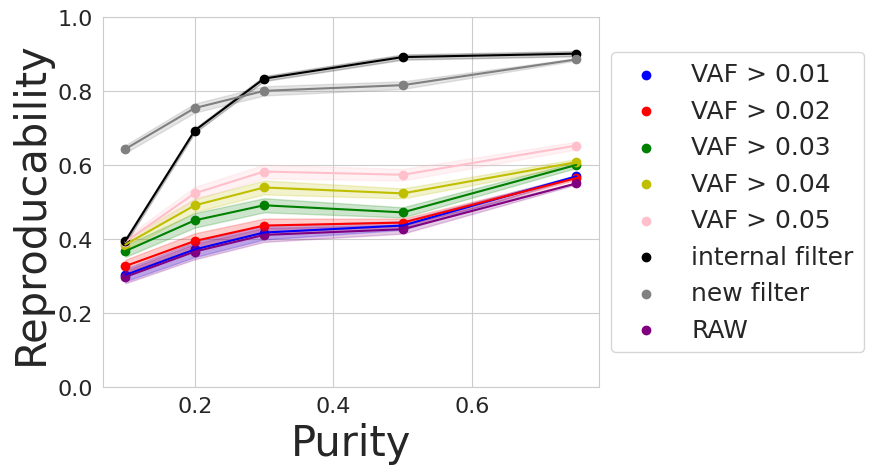

In [214]:
target_variants = ['SNP', 'DNP', 'TNP']

for color, VAF_threshold in zip(
    ['b', 'r', 'g', 'y', 'pink'],
    [0.01, 0.02, 0.03, 0.04, 0.05]
):
    plot_reproducability_from_maf(
        maf_ini_dict, maf_dict, color, label = f'VAF > {VAF_threshold}',
        ldt_pass=False, ldt_ml=False,
        basic=True, VAF_threshold=VAF_threshold
    )

plot_reproducability_from_maf(
    maf_ini_dict, maf_dict, color='black', label = 'internal filter',
    ldt_pass=True, ldt_ml=False,
    basic=False, VAF_threshold=0
)

plot_reproducability_from_maf(
    maf_ini_dict, maf_dict, color='grey', label = 'new filter',
    ldt_pass=False, ldt_ml=True,
    basic=False, VAF_threshold=0
)
 
plot_reproducability_from_maf(
    maf_ini_dict, maf_dict, color='purple', label = 'RAW',
    ldt_pass=False, ldt_ml=False,
    basic=False, VAF_threshold=0
)    
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0,1)
plt.xlabel('Purity')
plt.ylabel('Reproducability')

100%|██████████| 45/45 [00:00<00:00, 352.85it/s]


Text(0, 0.5, 'Reproducability')

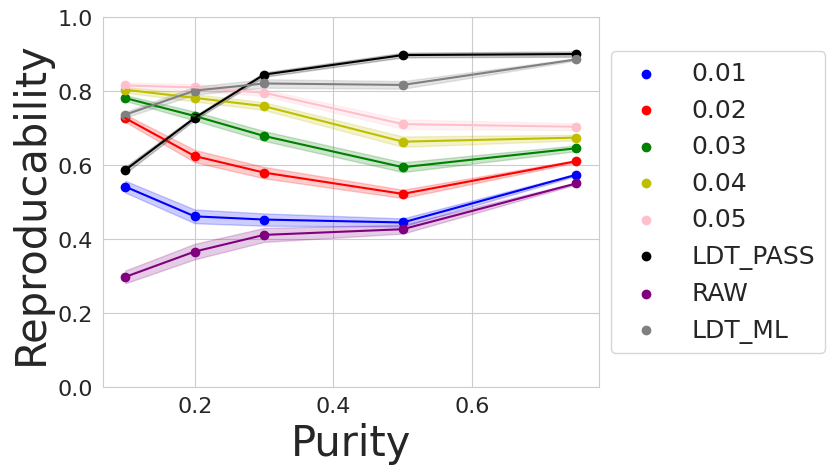

In [208]:
TF_snp_samples = {}
target_variants = ['SNP', 'DNP', 'TNP']

for color, VAF_threshold in zip(
    ['b', 'r', 'g', 'y', 'pink'],
    [0.01, 0.02, 0.03, 0.04, 0.05]
):
    plot_reproducability_from_maf_advanced(
        maf_ini_dict, maf_dict, color, label = VAF_threshold,
        ldt_pass=False, ldt_ml=False,
        basic=True, VAF_threshold=VAF_threshold
    )

plot_reproducability_from_maf_advanced(
    maf_ini_dict, maf_dict, color='black', label = 'LDT_PASS',
    ldt_pass=True, ldt_ml=False,
    basic=False, VAF_threshold=0
)
plot_reproducability_from_maf_advanced(
    maf_ini_dict, maf_dict, color='purple', label = 'RAW',
    ldt_pass=False, ldt_ml=False,
    basic=False, VAF_threshold=0
)

plot_reproducability_from_maf_advanced(
    maf_ini_dict, maf_dict, color='grey', label = 'LDT_ML',
    ldt_pass=False, ldt_ml=True,
    basic=False, VAF_threshold=0
)
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0,1)
plt.xlabel('Purity')
plt.ylabel('Reproducability')

## VAF vs purity

100%|██████████| 77/77 [00:00<00:00, 1487.42it/s]


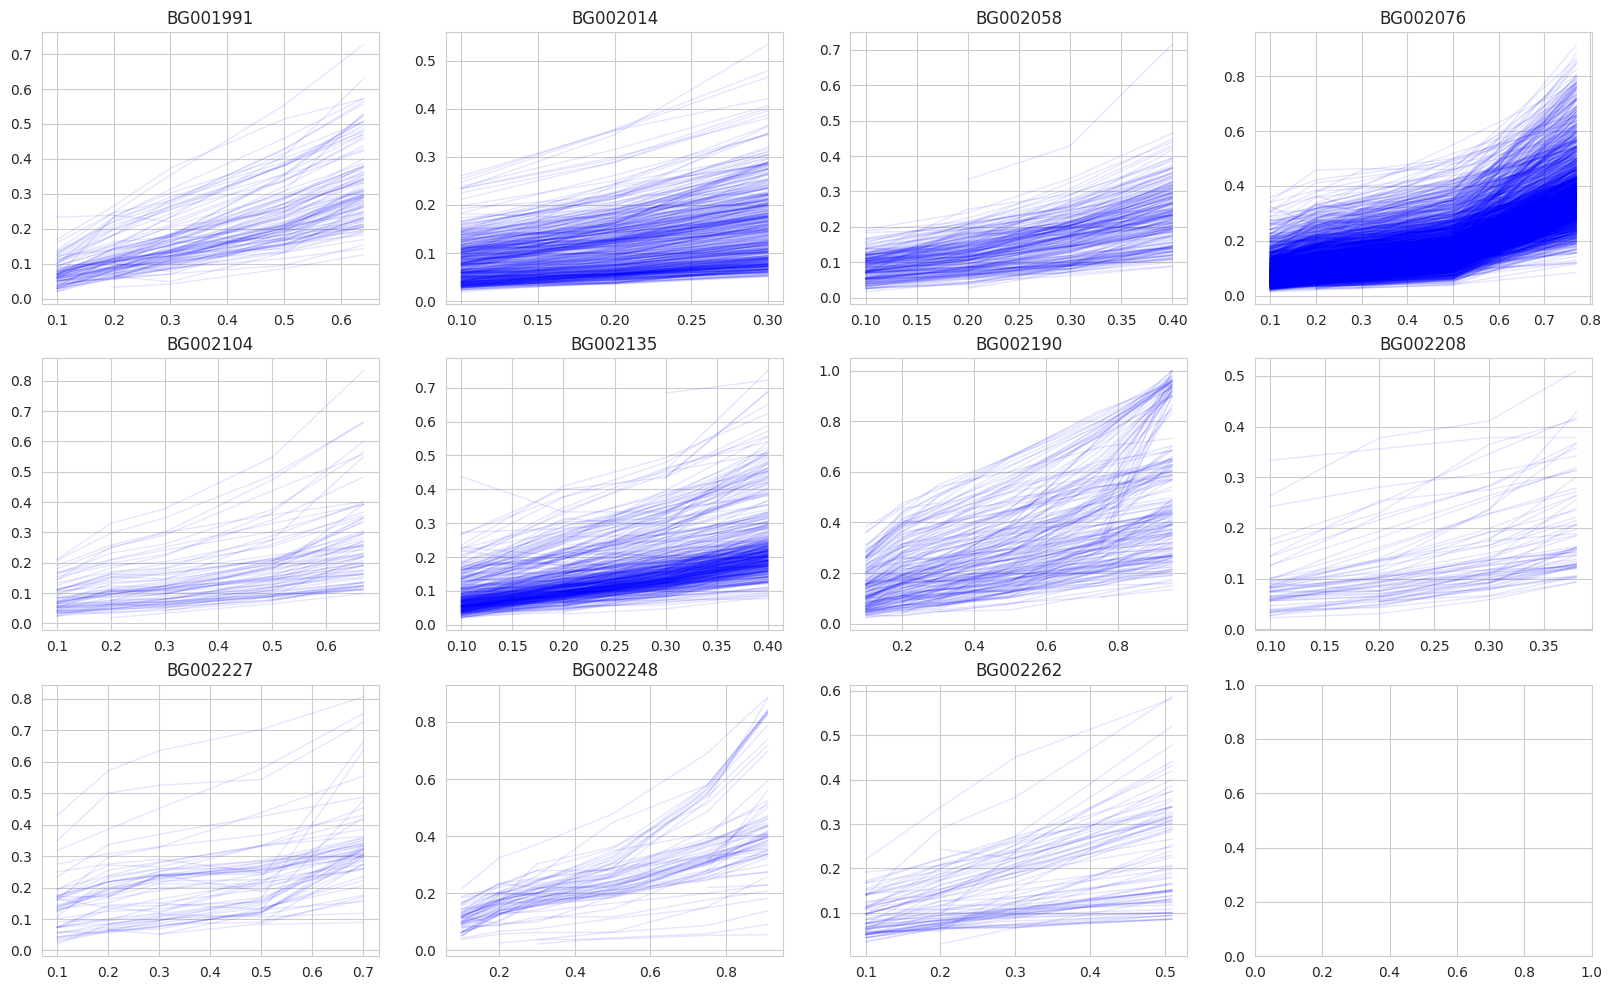

In [302]:
samples2plot = maf_ini_dict.keys()

fig, axs = plt.subplots(3, 4, figsize=(20, 12))

for ax, sample_ini in zip(axs.flat[:len(samples2plot)], samples2plot):
    samples_tmp = [sample for sample in sample2purity.keys() if sample.split('_')[0] == sample_ini]
    muts_VAF = pd.concat(
        [
            maf_dict[sample].Tumor_VAF for sample in samples_tmp
        ]+[maf_ini_dict[sample_ini].Tumor_VAF],
        axis=1
    )
    muts_VAF.columns = [sample2purity[sample] for sample in samples_tmp]+[meta_val_full_df.loc[sample_ini, 'Purity_hephaestus']]
    muts_VAF = muts_VAF[(~muts_VAF.isna()).sum(axis=1)>1]
    muts_VAF_LDT = muts_VAF[muts_VAF.index.isin(TP_mut_set_dict[sample_ini])]

    for vals in tqdm.tqdm(muts_VAF_LDT.values):
        mask = ~np.isnan(vals)
        ax.plot(
            muts_VAF_LDT.columns[mask],
            vals[mask],
            alpha=0.1,
            color='blue',
            linewidth=1,
        )
    ax.set_title(sample_ini)


100%|██████████| 85/85 [00:00<00:00, 1686.42it/s]


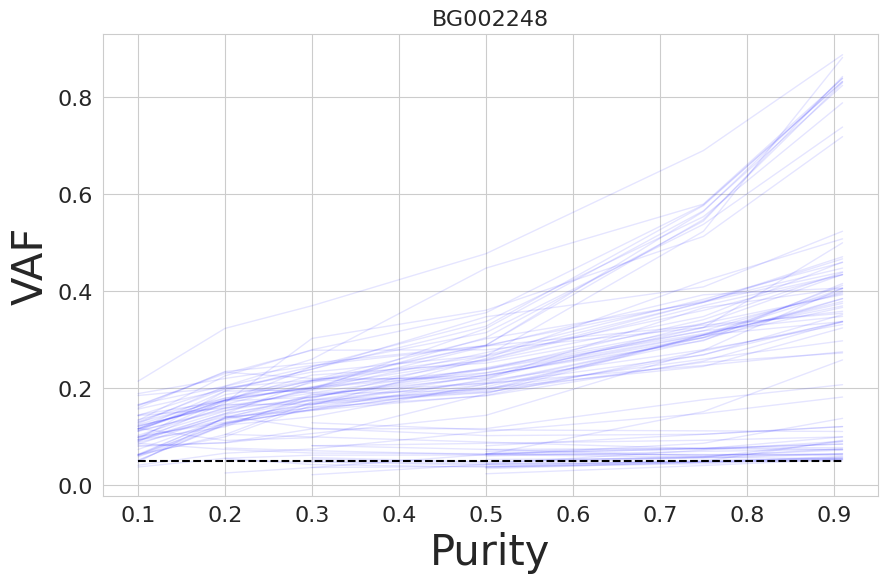

In [210]:
sample_ini = 'BG002248'
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

samples_tmp = [sample for sample in sample2purity.keys() if sample.split('_')[0] == sample_ini]
muts_VAF = pd.concat(
    [
        maf_dict[sample].Tumor_VAF for sample in samples_tmp
    ]+[maf_ini_dict[sample_ini].Tumor_VAF],
    axis=1
)
muts_VAF.columns = [sample2purity[sample] for sample in samples_tmp]+[meta_val_full_df.loc[sample_ini, 'Purity_hephaestus']]
muts_VAF = muts_VAF[(~muts_VAF.isna()).sum(axis=1)>2]
muts_VAF_LDT = muts_VAF[muts_VAF.index.isin(TP_mut_set_dict[sample_ini])]

for vals in tqdm.tqdm(muts_VAF_LDT.values):
    mask = ~np.isnan(vals)
    ax.plot(
        muts_VAF_LDT.columns[mask],
        vals[mask],
        alpha=0.1,
        color='blue',
        linewidth=1,
    )
ax.set_title(sample_ini)
ax.set_xlabel('Purity')
ax.set_ylabel('VAF')
plt.plot([0.1, 0.91], [0.05, 0.05], '--', color='black', )

# Generated data

## Introduced mutations

In [ ]:
mutations_path = os.path.join('..', 'mutations')

In [ ]:
index_df = pd.read_table(
    os.path.join(mutations_path, 'indel_1.txt'), header=None, 
    names = ['chrom', 'start', 'end', 'vaf', 'label', 'ins']
)

In [ ]:
snp_df = pd.read_table(
    os.path.join(mutations_path, 'snp_1.txt'), header=None, 
    names = ['chrom', 'start', 'end', 'vaf', 'label']
)

In [ ]:
ref_df = pd.concat([snp_df, index_df])
ref_df

In [ ]:
ref_array = ref_df.chrom.values + '_' + ref_df.start.values.astype(str)

In [ ]:
indel_array = index_df.chrom.values + '_' + index_df.start.values.astype(str)

## recall and precision

In [ ]:
# MODIFY
# diluted patients; naming should be in line with template
# <patient>_<purity>, where <patient> is name of
# initial sample and purity - expected purity
# depending on VAF of introduced mutations

generated_patients = []
path2generatedmafs = './'

In [ ]:
def plot_metric_for_generated_pats(
    column, metric2plot, color, generated_patients, 
    path2generatedmafs, maf_name, indel_array,
    ref_array
):
    
    tmp_list = []
    for sample in generated_patients:
        maf_path = os.path.join(path2generatedmafs, sample, maf_name)

        # MODIFY maf_processing function from imports
        maf = maf_processing(maf_path)

        purity = file.split('_')[-1]
        maf['ref_index'] = maf.Chromosome.values + '_' + np.where(
            maf.Variant_Type.isin(['INS']), maf.Start_Position+1, maf.Start_Position
        ).astype(str)

        if purity=='75':
            mask1 = maf['ref_index'].isin(indel_array)

        mask1 = maf['ref_index'].isin(ref_array)

        TP = (mask1 & (maf[column] =='PASS')).sum()
        TN = (~mask1 & ~(maf[column] =='PASS')).sum()
        FP = (~mask1 & (maf[column] =='PASS')).sum()
        FN = (mask1 & ~(maf[column] =='PASS')).sum()

        tmp_list.append(
            {'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN, 'purity':purity}
        )

    tmp_df = pd.DataFrame(tmp_list)
    tmp_df['recall'] = tmp_df.TP/(tmp_df.TP + tmp_df.FN)
    tmp_df['precision'] = tmp_df.TP/(tmp_df.TP + tmp_df.FP)
    tmp_df = tmp_df.sort_values(by='purity')

    plt.plot(tmp_df.purity, tmp_df[metric2plot], color = color)
    plt.scatter(tmp_df.purity, tmp_df[metric2plot], color = color)
    plt.ylim(0, 1)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


(0.0, 1.0)

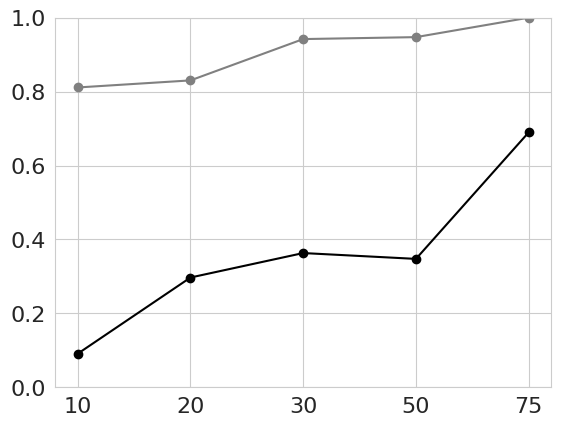

In [202]:
plot_metric_for_generated_pats(
    'LDT_ML', 'recall', 'grey', generated_patients, 
    path2generatedmafs, maf_name, indel_array,
    ref_arra
)
plot_metric_for_generated_pats(
    'LDT_PASS', 'precision', 'black', generated_patients, 
    path2generatedmafs, maf_name, indel_array,
    ref_arra
)